In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.stats import norm 
import seaborn as sns
sns.set_style('whitegrid')

plt.rc('figure',figsize=(10,6),dpi=100)

import json 
from requests import get

# Setup
Consider $m$ assets (in our case $m=6$ cryptocurrency/USD exchange prices), and 
denote by a $m$-dimensional
real valued stochastic process $\boldsymbol{p}_t$ their prices for the trading periods $t = 1,\ldots,T $.  
For each asset $i$ define
$$
x_{i,t} = \frac{p_{i,t}}{p_{i,t-1}} \quad i = 1\ldots m, \,\, t = 2,\ldots T
$$
That is today's close divided by yestarday's close, call this price relative vector $\boldsymbol{x}_t$, the vectors
$\{\boldsymbol{x}_1,\ldots, \boldsymbol{x}_T\}$ are usually called market vector.  
An investment strategy $\boldsymbol{B}$ is a sequence of vector valued functions 
$$\boldsymbol{b}_t: \mathbb{R}_+^{t-1} \rightarrow \Delta_m, \qquad \Delta_m = \{ \boldsymbol{b} \text{ s.t. } b_i \geq 0, \sum_{i=1}^m b_i = 1 \}
$$
so that $b_{i,t} = b_{i,t}(\boldsymbol{x}_1,\ldots,\boldsymbol{x}_{t-1})$ is the wealth invested in the $i$-th asset, given
past market vectors $\boldsymbol{x}_1,\ldots, \boldsymbol{x}_{t-1}$.  
The Wealth at the time horizon $T$ associated to strategy $\boldsymbol{B}$ is :
$$ 
S_T (\boldsymbol{B}) = S_0 \prod_{t = 1}^T \langle \boldsymbol{x}_t, \boldsymbol{b}_t \rangle
$$

We aim to measure the log-performance of the strategy: suppose $S_0 = 1$ and
$$
\log S_T (\boldsymbol{B}) = \sum_{t = 1}^T \log(\langle \boldsymbol{x}_t, \boldsymbol{b}_t \rangle )
$$
We define the regret wrt time horizon $T$ as 
$$
\begin{align*}
R_T &=  \mathop{\text{max}}_{\boldsymbol{b} \in \Delta_m} \log(S_T(\{\boldsymbol{b},\ldots,\boldsymbol{b}\})) -
\log(S_T(\boldsymbol B))  \\
 &= \sum_{t=1}^T -\log (\langle \boldsymbol{b}_t, \boldsymbol{x}_t \rangle) - 
 \mathop{\text{min}}_{\boldsymbol{b} \in \Delta_m} \sum_{t=1}^T (-\log (\langle \boldsymbol{b}, \boldsymbol{x}_t \rangle)\\
 &= \sum_{t=1}^T \ell_t(\boldsymbol{b}_t) -  \mathop{\text{min}}_{\boldsymbol{b} \in \Delta_m} \sum_{t=1}^T
 \ell_t(\boldsymbol{b})
\end{align*}
$$

The quantity $\mathop{\text{max}}_{\boldsymbol{b} \in \Delta_m} S_T(\{\boldsymbol{b},\ldots,\boldsymbol{b}\}) = S_T(\boldsymbol{B}^*)$ 
is the wealth associated to the best constant rebalanced portfolio (BCRP) $\boldsymbol{B}^*$ and $\ell_t(\boldsymbol b)$ is our loss function.

In [2]:
size = 500
port = ['BTC','ETH','USDT','XRP','BCH','BNB']
l = []
for sym in port:
    df = pd.DataFrame(get(f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={sym}&tsym=USD&limit={size}').json()['Data']['Data'])
    df.time = pd.to_datetime(df.time.values,unit='s')
    df.set_index('time',inplace=True)
    l.append(df['close'])
df = pd.concat(l,axis=1) 
df.columns=port

In [3]:
df.head()

,BTC,ETH,USDT,XRP,BCH,BNB
time,,,,,,
2019-07-01,10591.87,294.14,0.9968,0.4057,417.00,33.15
2019-07-02,10844.13,291.60,1.0010,0.3984,408.50,31.99
2019-07-03,11981.61,302.18,1.0040,0.4056,422.59,32.63
2019-07-04,11156.52,282.93,0.9996,0.3874,399.85,33.02
2019-07-05,10993.25,288.02,1.0020,0.3795,400.48,32.66


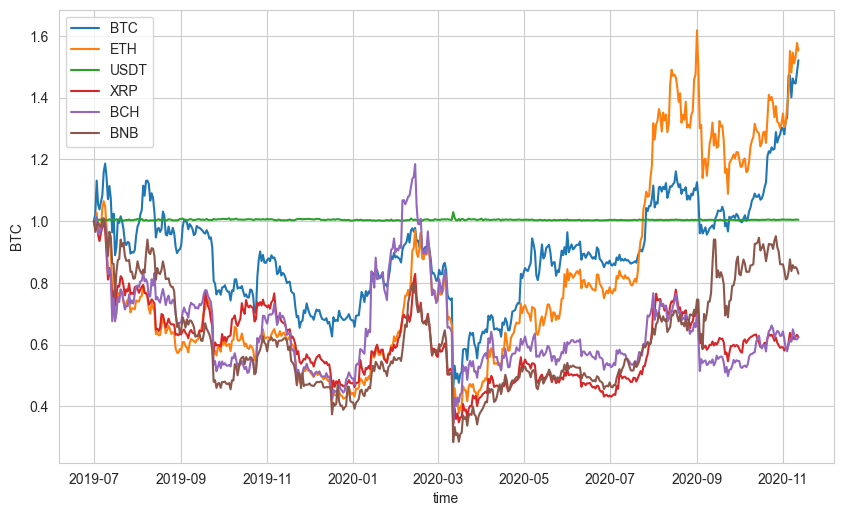

In [4]:
df_norm = df/df.iloc[0,:]
for s in port:
    sns.lineplot(y=s,x=df.index, data=df_norm,label=s)

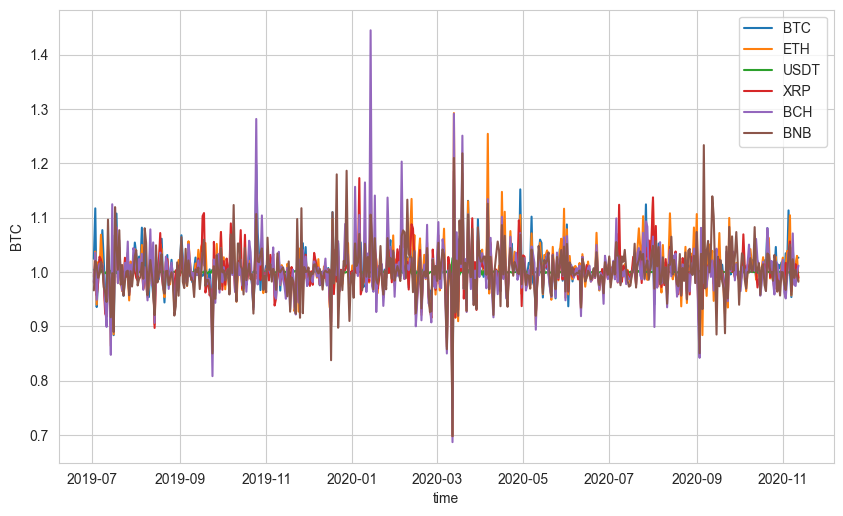

In [5]:
x = 1/(1-df.pct_change())
for s in port:
    sns.lineplot(y=s,x=df.index, data=x,label=s)
# x.dropna(inplace=True)

# Exponentiated Gradient
First it is customary in this case to linearize the loss function about $\boldsymbol{b}_t$:

$$
\begin{align*}
\ell_t(\boldsymbol{b}) 
- \ell_t(\boldsymbol{b}_t) &\geq \langle \nabla \ell_t(\boldsymbol{b}_t),\boldsymbol b - \boldsymbol{b}_t \rangle \\
\log (\langle \boldsymbol{b}_t, \boldsymbol{x}_t\rangle )
- \log (\langle \boldsymbol{b}, \boldsymbol{x}_t\rangle )
&\geq -
\frac{\boldsymbol{x}_t^T}{\langle \boldsymbol{b}_t, \boldsymbol{x}_t\rangle} (\boldsymbol b - \boldsymbol{b}_t)
\end{align*}
$$

With $\nabla \ell_t = \nabla {\ell_t}(\boldsymbol{b}_t) = -\frac{\boldsymbol x_t }{\langle \boldsymbol b_t , \boldsymbol x_t \rangle }$ as gradient loss function.
We use also a regularization term $\Phi$ (so that our new update $\boldsymbol{b}_{t+1}$ is not too far away 
from $\boldsymbol{b}_t$)

\begin{align*}
\boldsymbol{b}_{t+1} &= \mathop{\text{argmin}}_{\boldsymbol b \in \Delta_m} \, \left\{ \, \eta_t \langle \nabla \ell_t, \boldsymbol{b} \rangle + \Phi(\boldsymbol b ) \, \right\}
\end{align*}

If we choose $\Phi$ to be the (negative) Kullback-Leibler divergence of $\boldsymbol b$ from $\boldsymbol{b}_t$
$$
\Phi(\boldsymbol b) = \text{KL}(\boldsymbol b \| \boldsymbol b_{t})=  \sum_{i=1}^m b_i \log \frac{b_i}{b_{t,i}}
$$

Solving the constrained optimization problem above, we obtain the following update scheme

$$
b_{t,i} = \frac{b_{t-1,i}e^{-\eta_t \nabla \ell_{t,i}}}{
\sum_{i=1}^m b_{t-1,i}e^{-\eta_t \nabla \ell_{t,i}}} 
\qquad t = 1\ldots T
$$

Having fixed $b_{0,i} = \frac{1}{m}$ for every asset $i$.\\
Define the unnormalized portfolio weights as 

$$
\beta_{t,i} = \exp \left [-\sum_{s=1}^{t-1} \eta_s \nabla \ell_{s,i}\right ]
= \beta_{t-1,i} \,
 e^{-\eta_{t} \nabla \ell_{t,i} } 
$$

With $\beta_{0,i} = 1$.
Notice that summing from $i =1$ to $m$ in the previous
equation and dividing by $\sum_{i=1}^m \beta_{t-1,i}$ one
obtains

$$
\frac{\sum_{i=1}^m \beta_{i,t}}{\sum_{i=1}^m \beta_{i,t-1}}
 = \sum_{i=1}^m\frac{\beta_{t-1,i}e^{-\eta_t \nabla \ell_{t,i}}}{
\sum_{i=1}^m \beta_{t-1,i}} 
= \mathop{\mathbb E}_{\boldsymbol b_{t-1}} \left[
e^{-\eta_t \nabla \ell_{t}}
\right]
$$

Where the last term denotes the expectation taken with
respect the probability defined by vector $\boldsymbol b_{t-1}$.  
Suppose now that $\nabla \ell_{t}$ is such that $\max_{i=1\ldots m} |\nabla \ell_{t,i} | \leq M/2$ for 
any $t = 1 \ldots T$, then by Hoeffding bound we have 

$$
\log
\mathop{\mathbb E}_{\boldsymbol b_{t-1}} \left[
e^{-\eta_t \nabla \ell_{t}}
\right] \leq - \eta_{t} \langle \nabla \ell_{t}, \boldsymbol b_{t-1} \rangle  + \frac{\eta_t^2 M^2}{8}
$$

Now we bound LHS and RHS separately:
By summing from $t=1$ up to $T$ on LHS we get

$$
\begin{align*}
   \sum_{t=1}^T \log
\mathop{\mathbb E}_{\boldsymbol b_{t-1}} \left[
e^{-\eta_t \nabla \ell_{t}}
\right] &=  \log \left ( \sum_{t=1}^T \beta_{T,i}
\right) - \log m \quad &\text{previous relation}
\\
&\geq  \log \left ( \max_{i=1,\ldots,m} \beta_{T,i}
\right) - \log m, \qquad & \left [\max_{i=1,\ldots,m} \beta_{i}
 \leq \sum_{i=1}^m \beta_{i}, \,\, \beta_{i} \geq 0, \forall i \right]
\\
&=  \min_{i=1,\ldots,m} \, \sum_{t=1}^T \eta_{t} \nabla \ell_{t,i} - \log m ,\qquad &\left[-\min_x -f(x) = \max_x f(x) \right]
\end{align*}
$$

To bound the RHS we note:

$$
\begin{align*}
-\eta_t \langle \nabla \ell_t, \boldsymbol b_{t -1} \rangle &=
-\eta_t  \langle \nabla \ell_t, \boldsymbol b_{t -1} \rangle - \text{KL}
( \boldsymbol b_{t-1} \| \boldsymbol b_{t-1}) 
\qquad & \left[ \text{KL}(\boldsymbol b \| \boldsymbol b ) = 0\right] 
\\
&\leq -\eta_t \langle \nabla \ell_t, \boldsymbol b_{t} \rangle - \text{KL}
( \boldsymbol b_{t} \| \boldsymbol b_{t-1}) 
\qquad &\text{ update rule} 
\\
&\leq -\eta_t \langle  \nabla \ell_t, \boldsymbol b_{t} \rangle
\qquad & \left[ \text{KL}(\boldsymbol x \| \boldsymbol y ) \geq 0\right] 
\\
\end{align*}
$$

So finally, if we fix $\eta_t = \eta \geq 0$ constant, we obtain the regret bound 

$$
\sum_{t=1}^T \langle \nabla \ell_t , \boldsymbol b_t \rangle
- 
\min_{i=1,\ldots,m} \, \sum_{t=1}^T \eta_{t} \nabla \ell_{t,i}
\leq \frac{\log m}{\eta} +  \frac{\eta T M^2}{8}
= M \sqrt{ T \frac{\log m}{8}}
$$

for $\eta = \frac{1}{M} \sqrt{\frac{8}{T}\log m}$

In [6]:
def eg_update(b,ret,eta):
    den = ret.dot(b)
    ans = b * np.exp(eta*ret/den)
    return ans/ans.sum()

In [7]:
T, asset_num = x.shape
pprice = np.zeros(T)
eta = np.sqrt(8*np.log(T))
b = np.ones((T,asset_num)) * 1/asset_num
pprice[0] = b[0].dot(df.iloc[0,:])
for t in range(1,T):
    eta = np.sqrt(8*np.log(T)/t)
    b[t] = eg_update(b[t-1], x.iloc[t,:],eta)
    pprice[t] = b[t].dot(x.iloc[t,:]) * pprice[t-1]

In [8]:
ndf = df
ndf['pprice'] = pprice

<AxesSubplot:xlabel='time'>

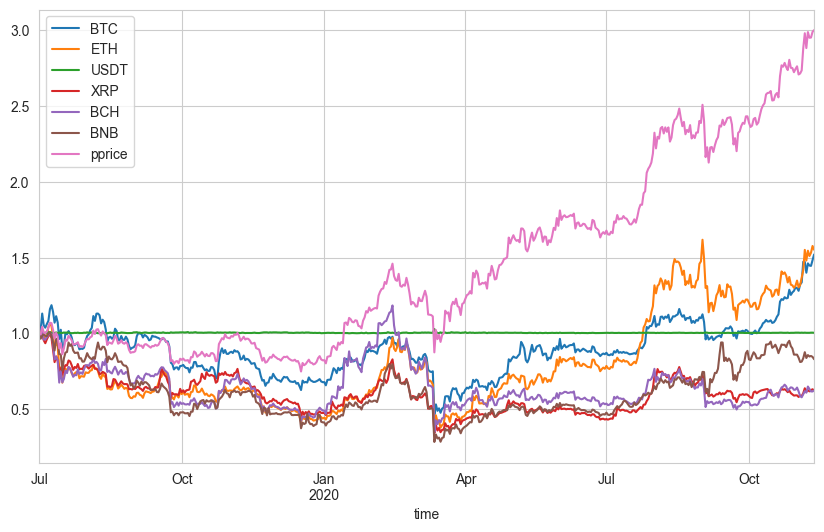

In [10]:
# fig = px.line(ndf/ndf.iloc[0,:],template='plotly_white')
# fig.show()
(ndf/ndf.iloc[0,:]).plot()
plt.title('Normalized plot $S_t,i/S_{0,i}')

In [28]:
size = 500
port = ['BTC','ETH','USDT','XRP','BCH','BNB']
datas = []
for sym in port:
    df = pd.DataFrame(get(f'https://min-api.cryptocompare.com/data/v2/histoday?fsym={sym}&tsym=USD&limit={size}').json()['Data']['Data'])
    df.time = pd.to_datetime(df.time.values,unit='s')
    df.set_index('time',inplace=True)
    df = df[['open','high','close','low']]
    datas.append(df)
# df.columns=port